# TROPICAL TRENDSETTERS
### Robin Mikeal and Jef Hinton

# Abstract
Hurricanes are a major concern for populations living in coastal areas, especially during the peak months of the Atlantic hurricane season from August to October. This project looks at hurricane patterns since 2000 using data from the National Oceanic and Atmospheric Administration (NOAA). The data includes information on storm paths, wind speeds, pressure, and ENSO (El Niño Southern Oscillation) phases to see how these climate cycles might affect storm intensity. The analysis confirms well-known patterns, like the inverse relationship between wind speed and pressure and the tendency for storms to weaken after landfall. However, the data shows that factors like spatial distance and ENSO phases don’t have a strong connection to storm intensity. 

# Overview: (Introduction) 

People who live, or who have relatives that live in hurricane prone areas often wait through the months of August through October with elevated levels of concern regarding the potential for "the big one" to directly impact their area.  This project aims to evaluate hurricane pattern data since 2000. This data is provided by the National Oceanic and Atmospheric Administration (NOAA).  Data types include location and path information, dates, wind speeds, and pressure.  An additional data set documenting the classification relative to the El Niño Southern Oscillation (ENSO) event cycles have been included to look for additional trends related to warm water, neutral, or cooler waters.  This workbook provides explaination on the data compilation, data cleaning, data visualization, and statistics.  The evaluation illustrates patterns that support commonly accepted concepts such as 1) that as wind speeds increase, pressure decreases, and 2) generally wind speeds decrease after the storm reaches a major landfall. However, some other concepts that are revealed is that spatial distance does not appear to have a strong relationship to wind speed or pressure.  Lastly, the evaluation displays that the ENSO events do not have a strong relationship to the intensity of the storms as measured by pressure. The data also shows that the mean wind speed for each storm falls within a normal distribution, although individual storms overall windspeed measurements do display a skewed right distriubtion. The authors conclude that this data may not be temporally extensive enough to make bolder predictions or assert relationships that would definitively reject the null hypothesis regarding the relationship between ENSO events and storm intensity.  But more historical data may be helpful in making further assessments about those potential relationships.
  

# Section 1:  Data Compiling  (Methods) 

Hurricane paths and intensities all came from:  https://bit.ly/3NNylR4

In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import geopandas as gpd
from branca.element import Element
import math

fig_counter = 0

## Section 1A:  Dataset 1 Compiling and Cleaning

In [2]:
original_df = pd.read_csv("GEO557Tropical_Storm_Dataset.csv") 
#
print(original_df.info())
original_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               2240 non-null   int64  
 1   Name               2240 non-null   object 
 2   BASIN              0 non-null      float64
 3   ISO_TIME_________  2240 non-null   object 
 4   NATURE             2240 non-null   object 
 5   LAT                2240 non-null   float64
 6   LON                2240 non-null   float64
 7   WMO WIND           1180 non-null   float64
 8   WMO PRES           1180 non-null   float64
 9   USA WIND           2240 non-null   int64  
 10  USA PRES           2240 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 192.6+ KB
None


Year    Name  BASIN    ISO_TIME_________ NATURE   LAT   LON  WMO WIND  \
0  2023  IDALIA    NaN  2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1  2023  IDALIA    NaN             15:00:00     TS  21.1 -86.1       NaN   
2  2023  IDALIA    NaN             18:00:00     TS  21.3 -86.2      25.0   
3  2023  IDALIA    NaN             21:00:00     TS  21.3 -86.3       NaN   
4  2023  IDALIA    NaN   2023-08-27 0:00:00     TS  21.1 -86.4      30.0   
5  2023  IDALIA    NaN              3:00:00     TS  20.8 -86.7       NaN   
6  2023  IDALIA    NaN              6:00:00     TS  20.5 -86.8      30.0   
7  2023  IDALIA    NaN              9:00:00     TS  20.2 -86.6       NaN   
8  2023  IDALIA    NaN             12:00:00     TS  19.9 -86.3      35.0   
9  2023  IDALIA    NaN             15:00:00     TS  19.9 -86.0       NaN   

   WMO PRES  USA WIND  USA PRES  
0    1006.0        25      1006  
1       NaN        25      1006  
2    1006.0        25      1006  
3       NaN        28      1005  
4    1004.0        30      1004  
5       NaN        30      1003  
6    1002.0        30      1002  
7       NaN        33      1001  
8     999.0        35       999  
9       NaN        38       998

In [3]:
def populate_full_dates(df): 
    #iterate through DF and fix dates 
    # Initialize variable to hold the last full date encountered
    current_date = None
    
    # Iterate through the ISO_TIME column and update times based on the last full date
    for i, iso_time in enumerate(df['ISO_TIME']):
        if len(iso_time) > 8:  # Full datetime (YYYY-MM-DD HH:MM:SS)
            # Set current_date to the full date part of the timestamp
            current_date = iso_time[:10]  # Extract the date portion (YYYY-MM-DD)
        else:
            # If only time is present, add the current_date to create a full timestamp
            df.at[i, 'ISO_TIME'] = f"{current_date} {iso_time}"
    
    # Convert ISO_TIME column to datetime for consistency
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
    return df 

# originally the data was gatherd from 23 different websites from NOAA historical hurricane tracks   https://bit.ly/3NNylR4
# the name and year columns I added as I gathered the data. 

# some issues with the dataset involve ISO time being seuqential, so the first one we're going to wrangle is  
# ISO_TIME____ column, the name and the data both need help. 
# YYYY-MM-DD but every other measurement in that section doesn't have that until it hits the next day 
# we're going to do the following 3 things, 
# 1. rename the iso_time column 
# 2. add dates to match the TIME
df = pd.read_csv("GEO557Tropical_Storm_Dataset.csv") 
# Step 1: Rename the ISO_TIME_________ column to ISO_TIME
df.rename(columns={'ISO_TIME_________': 'ISO_TIME'}, inplace=True)
df.head(5) 

# Step 2: we have to iterate through the data set, and if ISO_TIME has a full date in it, pull that out, and populate until it finds a new Full date 
df = populate_full_dates(df)

print(df.info())
df.head(10)
# notice the ISO_TIME column is uniform the year is paired with the timestamp. this will make our lives easier in the future. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Year      2240 non-null   int64         
 1   Name      2240 non-null   object        
 2   BASIN     0 non-null      float64       
 3   ISO_TIME  2240 non-null   datetime64[ns]
 4   NATURE    2240 non-null   object        
 5   LAT       2240 non-null   float64       
 6   LON       2240 non-null   float64       
 7   WMO WIND  1180 non-null   float64       
 8   WMO PRES  1180 non-null   float64       
 9   USA WIND  2240 non-null   int64         
 10  USA PRES  2240 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 192.6+ KB
None


Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0  2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1  2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2  2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3  2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4  2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
5  2023  IDALIA    NaN 2023-08-27 03:00:00     TS  20.8 -86.7       NaN   
6  2023  IDALIA    NaN 2023-08-27 06:00:00     TS  20.5 -86.8      30.0   
7  2023  IDALIA    NaN 2023-08-27 09:00:00     TS  20.2 -86.6       NaN   
8  2023  IDALIA    NaN 2023-08-27 12:00:00     TS  19.9 -86.3      35.0   
9  2023  IDALIA    NaN 2023-08-27 15:00:00     TS  19.9 -86.0       NaN   

   WMO PRES  USA WIND  USA PRES  
0    1006.0        25      1006  
1       NaN        25      1006  
2    1006.0        25      1006  
3       NaN        28      1005  
4    1004.0        30      1004  
5       NaN        30      1003  
6    1002.0        30      1002  
7       NaN        33      1001  
8     999.0        35       999  
9       NaN        38       998

 - The following filters were used to QA/QC the map to visualize different areas that were affected by less than Hurricane Force Category 1 winds.
 - If the maximum sustained wind per storm is less than 74, it should be removed from the dataset

In [4]:
filtered_df = df[(df['USA WIND'] <= 74)]

filtered_df

Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1     2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2     2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3     2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4     2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
...    ...     ...    ...                 ...    ...   ...   ...       ...   
2235  2004    IVAN    NaN 2004-09-23 21:00:00     TS  29.4 -92.9       NaN   
2236  2004    IVAN    NaN 2004-09-24 00:00:00     TS  29.6 -93.2      30.0   
2237  2004    IVAN    NaN 2004-09-24 02:00:00     TS  29.8 -93.6      30.0   
2238  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
2239  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   

      WMO PRES  USA WIND  USA PRES  
0       1006.0        25      1006  
1          NaN        25      1006  
2       1006.0        25      1006  
3          NaN        28      1005  
4       1004.0        30      1004  
...        ...       ...       ...  
2235       NaN        35      1003  
2236    1003.0        30      1003  
2237    1004.0        30      1004  
2238       NaN        29      1005  
2239    1009.0        25      1009  

[1473 rows x 11 columns]

It is important to check that all of the data included actually makes it to the minimum Category 1 Hurricane stage.  
This can be done by evaluating the wind speeds.

In [5]:
# Step 1: Find the maximum wind speed by Name
max_wind_by_name_1 = df.groupby('Name')['USA WIND'].max().reset_index()
print(max_wind_by_name_1)

        Name  USA WIND
0     ARTHUR        70
1    CHARLEY       130
2     DENNIS       130
3    DORIAN        160
4       ELSA        75
5        ETA       130
6    FRANCES       125
7     GORDON        70
8    HERMINE        70
9   HUMBERTO       110
10       IAN       140
11    IDALIA       115
12      IRMA       155
13    ISAIAS        80
14      IVAN       145
15    JEANNE       105
16   KATRINA       150
17   MATTHEW       145
18   MICHAEL       140
19    NICOLE        65
20   OPHELIA        75
21      RITA       155
22     SALLY        95
23     WILMA       160


In [6]:
# Step 2: Make a list of all storms that never achieve sustained winds above 74 mph.

TS = max_wind_by_name_1[max_wind_by_name_1['USA WIND'] < 74]['Name'].tolist()
print(TS)

['ARTHUR', 'GORDON', 'HERMINE', 'NICOLE']


This illustrates that there are four storms with max wind less than the critical 74 mph to be a Category 1 storm.  
These were removed from the dataset.

In [7]:
dfCat1 = df[~df['Name'].isin(['ARTHUR', 'GORDON', 'HERMINE', 'NICOLE'])]
dfCat1

Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1     2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2     2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3     2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4     2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
...    ...     ...    ...                 ...    ...   ...   ...       ...   
2235  2004    IVAN    NaN 2004-09-23 21:00:00     TS  29.4 -92.9       NaN   
2236  2004    IVAN    NaN 2004-09-24 00:00:00     TS  29.6 -93.2      30.0   
2237  2004    IVAN    NaN 2004-09-24 02:00:00     TS  29.8 -93.6      30.0   
2238  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
2239  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   

      WMO PRES  USA WIND  USA PRES  
0       1006.0        25      1006  
1          NaN        25      1006  
2       1006.0        25      1006  
3          NaN        28      1005  
4       1004.0        30      1004  
...        ...       ...       ...  
2235       NaN        35      1003  
2236    1003.0        30      1003  
2237    1004.0        30      1004  
2238       NaN        29      1005  
2239    1009.0        25      1009  

[1956 rows x 11 columns]

### Explanation of Dataset 1 Compiling
- This data set contains Catagory 1 through Category 5 hurricanes that have entered the radius of 500 miles from Tampa, Florida from 2000 to 2023.
 - WMO Wind and WMO Pressure contained NaNs, so, USA WIND and USA PRES (which contain the average of the two nearest readings) have been used throughout below.
 - This study was inspired by the many devastating hurricanes that have struck this US this year.  
 - Hurricane Milton (October 2024) was not included in the National Historic Dataset at the time of the development of the code.  
 - Therefore Hurricane Milton data was downloaded directly from NOAA, but was not included in the initial analysis or cleaning and compiling.  
 - However, it is displayed as an overlay for spatial reference on the map below.

In [8]:
#import Milton overlay
Milton = pd.read_csv("MILTON_AL142024_pts.csv") 
# import, get info and head to prove data exists. 
print(Milton.info())
Milton.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   STORMNAME  22 non-null     object
 1   DTG        22 non-null     int64 
 2   YEAR       22 non-null     int64 
 3   MONTH      22 non-null     int64 
 4   DAY        22 non-null     int64 
 5   HHMM       22 non-null     int64 
 6   MSLP       22 non-null     int64 
 7   BASIN      22 non-null     object
 8   STORMNUM   22 non-null     int64 
 9   STORMTYPE  22 non-null     object
 10  INTENSITY  22 non-null     int64 
 11  SS         22 non-null     int64 
 12  LAT        22 non-null     int64 
 13  LON        22 non-null     int64 
dtypes: int64(11), object(3)
memory usage: 2.5+ KB
None


STORMNAME         DTG  YEAR  MONTH  DAY  HHMM  MSLP BASIN  STORMNUM  \
0  FOURTEEN  2024100512  2024     10    5  1200  1007    al        14   
1    MILTON  2024100518  2024     10    5  1800  1006    al        14   
2    MILTON  2024100600  2024     10    6     0  1006    al        14   
3    MILTON  2024100606  2024     10    6   600  1000    al        14   
4    MILTON  2024100612  2024     10    6  1200   991    al        14   
5    MILTON  2024100618  2024     10    6  1800   987    al        14   
6    MILTON  2024100700  2024     10    7     0   981    al        14   
7    MILTON  2024100706  2024     10    7   600   972    al        14   
8    MILTON  2024100712  2024     10    7  1200   943    al        14   
9    MILTON  2024100718  2024     10    7  1800   909    al        14   

  STORMTYPE  INTENSITY  SS  LAT  LON  
0        TD         30   0   22  -96  
1        TS         35   0   23  -96  
2        TS         35   0   23  -96  
3        TS         45   0   23  -95  
4        TS         55   0   23  -95  
5        HU         70   1   23  -94  
6        HU         75   1   23  -93  
7        HU         90   2   22  -93  
8        HU        120   4   22  -92  
9        HU        150   5   22  -91

## Section 1B: Dataset 2

The El Niño Southern Oscillation (ENSO), a natural climate pattern that involves changes in the temperature of the Pacific Ocean and the atmosphere:
El Niño: A warming of the ocean surface in the central and eastern tropical Pacific Ocean. This phase is characterized by reduced rainfall over Indonesia and increased rainfall over the central and eastern tropical Pacific Ocean.
La Niña: A cooling of the ocean surface in the central and eastern tropical Pacific Ocean. This phase is characterized by stronger east to west surface winds.
Southern Oscillation: The atmospheric counterpart to El Niño and La Niña  (SOURCE:  NOAA, 2024).

- A spreadsheet of the ENSO patterns was compiled and saved as a .csv.  
- This was then merged with the cleaned data to create a new column called "ENSO" in our data frame.

In [9]:
dfENSO = pd.read_csv("ENSO_Years.csv") 
# import, get info and head to prove data exists. 
print(dfENSO.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    128 non-null    int64 
 1   ENSO    128 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB
None


In [10]:
#Optional QA Check for checking that all data is showing up
# Filter records for Year 2005
#records_2005 = df2[df2['Year'] == 2005]
#records_2005

# Group by Year and count unique names
#grouped_unique_count = df2.groupby('Year')['Name'].nunique().reset_index(name='Unique Name Count')
#grouped_unique_count

#print(df2.info())

In [11]:
#merge ENSO Year Table with the Hurricane Path dataframe
df2 = pd.merge(dfCat1, dfENSO, on='Year')
print(df2)

      Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1     2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2     2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3     2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4     2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
...    ...     ...    ...                 ...    ...   ...   ...       ...   
1951  2004    IVAN    NaN 2004-09-23 21:00:00     TS  29.4 -92.9       NaN   
1952  2004    IVAN    NaN 2004-09-24 00:00:00     TS  29.6 -93.2      30.0   
1953  2004    IVAN    NaN 2004-09-24 02:00:00     TS  29.8 -93.6      30.0   
1954  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
1955  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   

      WMO PRES  USA WIND  USA PRES     ENSO  
0       1006.0   

It might be helpful to add another column containing the actual storm categories for purposes of more quickly and intuitively slicing the data.  So, a function was used below to define a new column based on the NOAA wind speed ranges for hurricane categories. 

In [12]:
def category(wind_speed):
    if wind_speed < 74:
        return 'Tropical Storm'   
    elif 74 >= wind_speed < 95:
        return 'Category 1'
    elif 95 >= wind_speed < 110:
        return 'Category 2'  
    elif 110 >= wind_speed < 129:
        return 'Category 3'  
    else:
        return 'Category 4+'  

# Apply the category function to create a new column
df2['Category'] = df2['USA WIND'].apply(category)

# Display the DataFrame with the new column
print(df2)

      Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1     2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2     2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3     2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4     2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
...    ...     ...    ...                 ...    ...   ...   ...       ...   
1951  2004    IVAN    NaN 2004-09-23 21:00:00     TS  29.4 -92.9       NaN   
1952  2004    IVAN    NaN 2004-09-24 00:00:00     TS  29.6 -93.2      30.0   
1953  2004    IVAN    NaN 2004-09-24 02:00:00     TS  29.8 -93.6      30.0   
1954  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
1955  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   

      WMO PRES  USA WIND  USA PRES     ENSO        Category  
0

## Section 1C: Dataset 3

It would also be useful to know the relationship of the individual measurement and their geographic position over land vs. ocean. This analysis was done using ArcGIS, but then has been exported as a .csv for inclusion here.  For the ArcGIS process, the original dataframe points are plotted using the latitude and longitude and a selection tool is used to select points that intersect the area identified as a landmass from the Earth Resource Land dataset.  A new column was created with a binomial indicator of being on land or not. This was then loaded and merged with the existing dataframe.

In [13]:
dfLand = pd.read_csv("StormswLandColumn.csv") 
# import, get info and head to prove data exists. 
print(dfLand.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   OBJECTID  2240 non-null   int64  
 1   Year      2240 non-null   int64  
 2   Name      2240 non-null   object 
 3   BASIN     0 non-null      float64
 4   ISO_TIME  2240 non-null   object 
 5   NATURE    2240 non-null   object 
 6   LAT       2240 non-null   float64
 7   LON       2240 non-null   float64
 8   WMO_WIND  1180 non-null   float64
 9   WMO_PRES  1180 non-null   float64
 10  USA_WIND  2240 non-null   int64  
 11  USA_PRES  2240 non-null   int64  
 12  LAND      2240 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 227.6+ KB
None


In [14]:
# Convert ISO_TIME columns to datetime64[ns] type
df2['ISO_TIME'] = pd.to_datetime(df2['ISO_TIME'])
dfLand['ISO_TIME'] = pd.to_datetime(dfLand['ISO_TIME'])

#merge Land Table with the df2 dataframe
# Merge df2 and dfLand on 'ISO_TIME' to add the Land column to df2
df2 = pd.merge(df2, dfLand[['ISO_TIME', 'LAND']], on='ISO_TIME', how='left')

print(df2)

      Year    Name  BASIN            ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2023  IDALIA    NaN 2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1     2023  IDALIA    NaN 2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2     2023  IDALIA    NaN 2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3     2023  IDALIA    NaN 2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4     2023  IDALIA    NaN 2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
...    ...     ...    ...                 ...    ...   ...   ...       ...   
2333  2004    IVAN    NaN 2004-09-24 02:00:00     TS  29.8 -93.6      30.0   
2334  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
2335  2004    IVAN    NaN 2004-09-24 03:00:00     TS  29.9 -93.8       NaN   
2336  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   
2337  2004    IVAN    NaN 2004-09-24 06:00:00     TS  30.1 -94.2      25.0   

      WMO PRES  USA WIND  USA PRES     ENSO        Category LAN

# Section 2:  Results

With the data compiled and cleaned, it is helpful to begin evaluating the data by visualizing the data distributions in different ways.  This data can be examined spatially on a map, can be grouped and examined per storm, and cross-examined between storms and their relevance to differnet ENSO events. This is presented in Section 2A.  Visualizing the data is helpful for determining which statistical comparisons may be useful for evaluation.  Statistical evaluations are presented in Section 2B.

## Section 2A:  Data Visualization

 - The following code produces a color-blind friendly map showing the cleaned dataset (2000-2023 Storms Traveling within a 500 Mi Radius of Tampa).
 - We chose a soft rainbow palette of complimentary colors to illustrate wind intensity into bins as defined by NOAA: 
         https://www.noaa.gov/education/resource-collections/weather-atmosphere/hurricanes?os=vb_&ref=app
 - The map also includes an overlay of Hurricane Milton (2024)
 - The map is interactive.  It can be zoomed in and out, and if one clicks on the dots, a pop-up flag with data about the storm will appear.
 - The map also includes a legend, however it is not linked to the get_color function, and must be manually changed if color changes are desired.

In [15]:
# Function to determine the color based on wind speed
def get_color(wind_speed):
    if wind_speed < 74:
        return '#56B4E9'   # soft blue
    elif 74 <= wind_speed < 95:
        return '#009E73'   # deep green
    elif 95 <= wind_speed < 110:
        return '#F0E442'  # bright yellow
    elif 110 <= wind_speed < 129:
        return '#E69F00'  # warm yellow-orange
    elif wind_speed >= 129:
        return '#D55E00'   # vibrant orange

# Filter the DataFrame to include only the hurricane data with wind >= 40 mph
hurricane_path = df2[df2['USA WIND'] >= 40].dropna(subset=['LAT', 'LON'])

# Create a map centered around Florida with OpenStreetMap tiles
m = folium.Map(
    location=[hurricane_path['LAT'].mean(), hurricane_path['LON'].mean()],
    tiles='OpenStreetMap',
    zoom_start=4
)

# Group by 'Name' to connect points of the same hurricane
for name, group in hurricane_path.groupby('Name'):
    previous_location = None
    previous_color = None

    # Add markers for each point in the group
    for _, row in group.iterrows():
        location = [row['LAT'], row['LON']]
        popup = f"{row['Name']}<br>Wind: {row['USA WIND']} mph<br>Pressure: {row['USA PRES']} hPa"
        
        # Get the color based on the wind speed
        color = get_color(row['USA WIND'])

        # Add a circle marker for each data point
        folium.CircleMarker(
            location=location,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=popup
        ).add_to(m)

        # Draw a polyline from the previous point to the current point, if a previous point exists
        if previous_location is not None:
            folium.PolyLine(
                locations=[previous_location, location],
                color=previous_color,  # Set line color to previous point's color
                weight=2,
                dash_array='5, 5'  # Dashed line effect
            ).add_to(m)

        # Update the previous point information
        previous_location = location
        previous_color = color

#TEST CSV Milton
def add_marker(map_obj, location, popup, color):
    folium.CircleMarker(
        location=location,
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=popup
    ).add_to(map_obj)

for name, group in Milton.groupby('STORMNAME'):
    previous_location = None
    previous_color = None

    for _, row in group.iterrows():
        location = [row['LAT'], row['LON']]
        popup = f"{row['STORMNAME']}<br>Wind: {row['INTENSITY']} mph<br>Pressure: {row['MSLP']} hPa"
        color = get_color(row['INTENSITY'])

        add_marker(m, location, popup, color)

        if previous_location is not None:
            folium.PolyLine(
                locations=[previous_location, location],
                color='black',  # Changed line color to black
                weight=3,).add_to(m)

        previous_location = location
        previous_color = color

# Add legend for data points
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 230px; height: 160px; 
     border:2px solid grey; z-index:9999; font-size:10x;
     background-color:white;
     padding: 10x
     ">
     <b>Legend</b><br>
     &nbsp;<i class="fa fa-circle" style="color:#56B4E9"></i>&nbsp; <74 mph: Tropical Storm<br>
     &nbsp;<i class="fa fa-circle" style="color:#009E73"></i>&nbsp; 74-95 mph: Cat. 1 Hurricane<br>
     &nbsp;<i class="fa fa-circle" style="color:#F0E442"></i>&nbsp; 96-110 mph: Cat. 2 Hurricane<br>
     &nbsp;<i class="fa fa-circle" style="color:#E69F00"></i>&nbsp; 111-129 mph: Cat. 3 Hurricane<br>
     &nbsp;<i class="fa fa-circle" style="color:#D55E00"></i>&nbsp; >=130 mph: Cat. 4 Hurricane +<br>
     &nbsp;<i class="fa fa-minus" style="color:black"></i>&nbsp; Milton's Path (2024)
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

legend = Element(legend_html)
m.get_root().add_child(legend)

# increment fig_counter
fig_counter = fig_counter + 1 
# Add map title outside of the map
title_html = '''
<h3 style="text-align:center; margin-top: 20px;">Figure ''' + str(fig_counter) + ''' - Hurricanes within 500 Miles from Tampa, Florida from 2000 to 2023</h3>
'''
title_element = Element(title_html)
m.get_root().html.add_child(title_element)

# Display the map
m

Figure 1, an interactive follium plot, shows the paths and intensities of all the storms in our study. These storm paths were selected based on, if they reached Category 1 status, and intersected with Florida. And gathered from historical hurricane tracks https://bit.ly/3Ct3Ygw when using the interactive version of this plot you can zoom in different portions of Florida. It seems like over the last 20 years some sections of Florida have experienced multiple Category 3 hurricanes, while others have primarily recieved tropical storms.

In the last 20 years, Tampa had not experienced a direct-hit storm.  Hurricane Milton in Oct. 2024 has been the closest.  Severe wind and storm surge pose the greatest risks accompanying a direct hit.  However, storms in the past that have skirted past Tampa traveling North (i.e. Hurricane Irma) have brought immense rainfall that leads to flooding.  

This data show the path and intensity of the storms.  What starts of blue as a Tropical Storm had to grow into at least a Category 1 Hurricane to be included in this dataset.  As the hurricanes weaken, they often fall back down into the blue Tropical Storm range. 

In [16]:
#install required library if not previously installed 
#pip install geopy

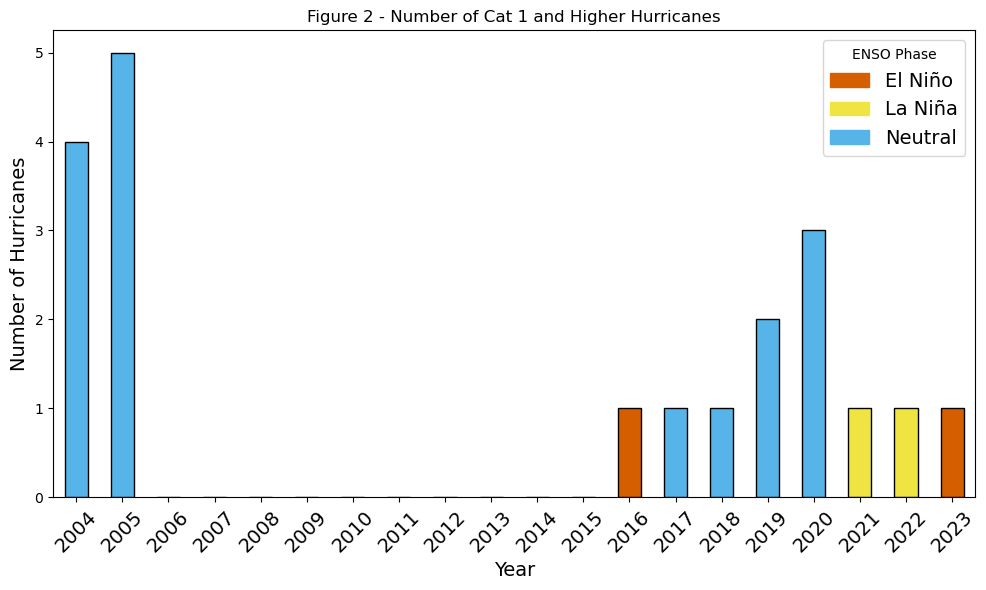

In [17]:
fig_counter = fig_counter + 1 
# Group by year and count unique storm names
storm_counts = df2.groupby('Year')['Name'].nunique()

# Create a range of years
all_years = pd.Series(range(df2['Year'].min(), df2['Year'].max() + 1), name='Year')

# Fill in missing years with 0
storm_counts = storm_counts.reindex(all_years, fill_value=0)

# Create a color map based on ENSO phases
enso_colors = {
    'El Niño': '#D55E00',
    'La Niña': '#F0E442',
    'Neutral': '#56B4E9'
}

# Map colors to the years based on ENSO phases
colors = df2.drop_duplicates('Year').set_index('Year')['ENSO'].reindex(all_years).map(enso_colors)

# Replace NaN values in colors with a default color (e.g., gray)
colors = colors.fillna('gray')

# Plot the data
plt.figure(figsize=(10, 6))
storm_counts.plot(kind='bar', color=colors, edgecolor='black')
# Label stuff
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Hurricanes', fontsize=14)
plt.title('Figure '+ str(fig_counter) +' - Number of Cat 1 and Higher Hurricanes')
plt.xticks(rotation=45, fontsize=14)

# Add legend for colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in enso_colors.values()]
labels = enso_colors.keys()
plt.legend(handles, labels, title="ENSO Phase", fontsize=14)

plt.tight_layout()
plt.show()

Figure 2 shows the count of hurricanes per year by ENSO phase colors. The most active year was 2005 which was catagorized as Neutral. The gap between 2006 and 2013 illustrates that no Catagory 1 storms that intersected with Florida during those years.  

Overall, this suggests that based on the temporal range of the data and the limited location, a visual relationship between ENSO and the number of hurricanes are not apparent.  However, a longer study periods and larger geographic areas may reveal other visual trends.  

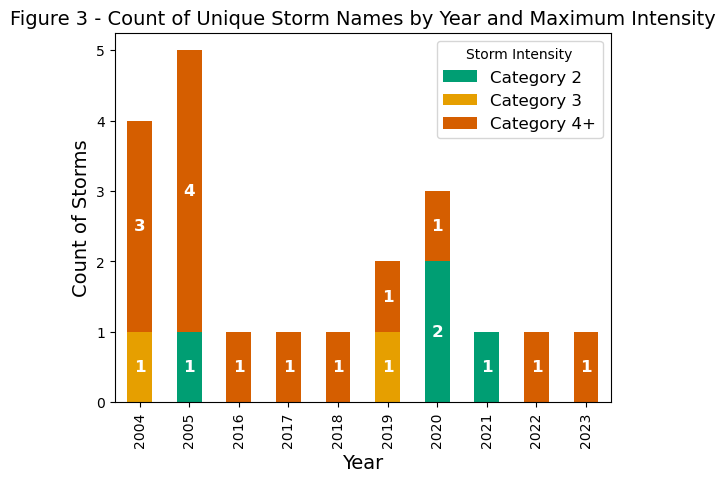

In [18]:
fig_counter = fig_counter + 1 
# Find Max Wind by name, then group by year and category, then count unique storm names
# Step 1: Find the maximum wind speed by Name
max_wind_by_name = df2.groupby('Name')['USA WIND'].max().reset_index()

# Step 2: Merge this back with the original DataFrame to keep other columns
MAX = df2.merge(max_wind_by_name, on=['Name', 'USA WIND'])

# Step 3: Group by Year and Category, then count unique Names
result = MAX.groupby(['Year', 'Category'])['Name'].nunique().unstack().fillna(0)

# Define custom color map
custom_colors = ['#009E73', '#E69F00', '#D55E00', '#56B4E9']

# Plotting the stacked bar chart with custom color map and white bold labels of counts
ax = result.plot(kind='bar', stacked=True, color=custom_colors)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Storms', fontsize=14)
plt.title('Figure ' + str (fig_counter) + ' - Count of Unique Storm Names by Year and Maximum Intensity', fontsize=14)
plt.legend(title='Storm Intensity', fontsize=12)

# Adding white bold labels of counts and removing zero labels
for container in ax.containers:
    labels = [int(v) if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', color='white', weight='bold', fontsize=12)

plt.show()

Figure 3 shows the year, intensity and number of storms. 2005 was the most active year with 5 storms, and 4 of them were Category 4 or higher. And like above, you can see a gap from 2006 to 2013.

It was suspected that El Niño and the ENSO patterns may relate with certain other measured data from the hurricanes.  So, the ENSO categorization was compared to sustained wind speeds and is shown below in Figure 4.  

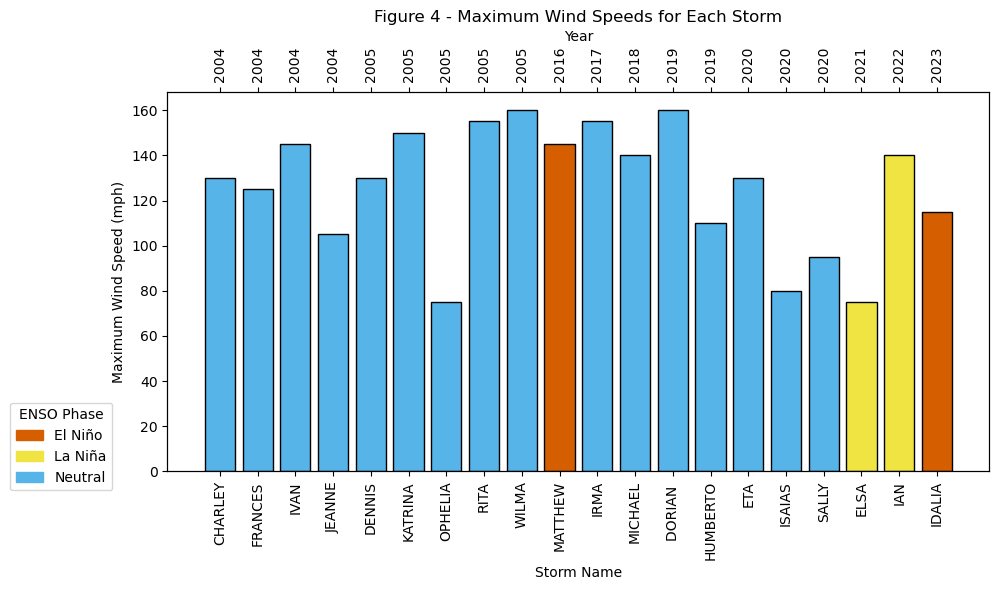

In [19]:
fig_counter = fig_counter + 1 
# Group by storm name and get the maximum wind speed for each storm
max_wind_speeds = df2.groupby(['Year', 'Name'])['WMO WIND'].max().reset_index()

# Sort by year
max_wind_speeds = max_wind_speeds.sort_values(by='Year')

# Create a color map based on ENSO phases
enso_colors = {
    'El Niño': '#D55E00',
    'La Niña': '#F0E442',
    'Neutral': '#56B4E9'
}

# Map colors to the years based on ENSO phases
colors = df2.drop_duplicates('Year').set_index('Year')['ENSO'].map(enso_colors)

# Replace NaN values in colors with a default color (e.g., gray)
colors = colors.fillna('gray')

# Ensure the colors Series is aligned with the max_wind_speeds index
colors = colors.reindex(max_wind_speeds['Year']).values

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the maximum wind speeds
bars = ax1.bar(max_wind_speeds['Name'], max_wind_speeds['WMO WIND'], color=colors, edgecolor='black')

# Label stuff for the first axis
ax1.set_xlabel('Storm Name')
ax1.set_ylabel('Maximum Wind Speed (mph)')
ax1.set_title('Figure ' + str(fig_counter) + ' - Maximum Wind Speeds for Each Storm')
ax1.tick_params(axis='x', rotation=90)

# Add legend for colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in enso_colors.values()]
labels = enso_colors.keys()
plt.legend(handles, labels, title="ENSO Phase", loc='upper left', bbox_to_anchor=(-0.2, 0.2))

# Create a second x-axis to show the year labels
ax2 = ax1.twiny()

# Set the second x-axis limits to match the first x-axis
ax2.set_xlim(ax1.get_xlim())

# Set the second x-axis ticks and labels to show the years
ax2.set_xticks(range(len(max_wind_speeds)))
ax2.set_xticklabels(max_wind_speeds['Year'], rotation=90)

# Set the second x-axis label
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

Figure 4 illustrates a plot of maximum wind speed per hurricane, and we're differentiating between El Niño, La Niña and neutral. Based on this chart and sample size, no visible relationship appears that may link El Niño or La Niña with stronger wind speeds or more storms.  Additional temporal analysis may with historic and future weather data, and a more widespread geographic footprint may reveal more apparent visual patterns. 

Wind speed and atmospheric pressure is commonly known to have an inverse relationship in hurricanes. This can be visualized using linear regression.

In [20]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [22]:
#how many columns have NaNs?
nans_in_columns = df2.isna().sum()
print(nans_in_columns)

Year           0
Name           0
BASIN       2338
ISO_TIME       0
NATURE         0
LAT            0
LON            0
WMO WIND    1111
WMO PRES    1111
USA WIND       0
USA PRES       0
ENSO           0
Category       0
LAND           0
dtype: int64


In [23]:
#we need to drop columns that have NaNs
LR = df2.drop(columns=['BASIN'])

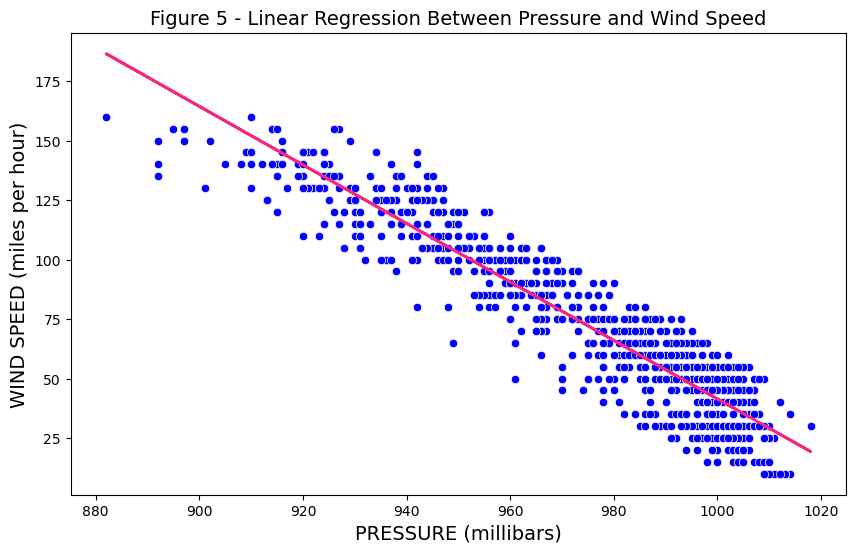

In [24]:
### Linear Regression of Pressure and Wind
fig_counter = fig_counter + 1 

# Drop rows with NaN values
LR = LR.dropna(subset=['WMO WIND', 'WMO PRES'])

# Extract the relevant columns
X = LR[['WMO PRES']]
y = LR['WMO WIND']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WMO PRES', y='WMO WIND', data=LR, color='blue')
plt.plot(LR['WMO PRES'], y_pred, color='#F62681', linewidth=2)
plt.xlabel('PRESSURE (millibars)', fontsize=14)
plt.ylabel('WIND SPEED (miles per hour)', fontsize=14)
plt.title('Figure ' + str(fig_counter) +' - Linear Regression Between Pressure and Wind Speed', fontsize=14)
plt.show()


In the linear regression plot, Figure 5, the inverse relationship of wind speed and pressure is apparent. As pressure increases, windspeed decreases. Or in reverse, the lower the pressure, the higher the windspeed.  Storms thrive under low pressure systems.  High pressure systems create cooler, drier weather.  This kills a storm.  Low pressure breeds warm, humid conditions.  Hurricanes love the warm water.  

## Section 2b: Data Statistics

Statistics are useful in understanding the normality of the data, the relative distribution of results within a single storm, and for comparison of the storms to each other over time.  
In this section medians, boxplots ilustrating percentages and skewedness, means and spatial statistics will be evaluated and displayed.  Spatial statistics will display what happens to hurricane windspeed once the hurricane impacts a landmass. 

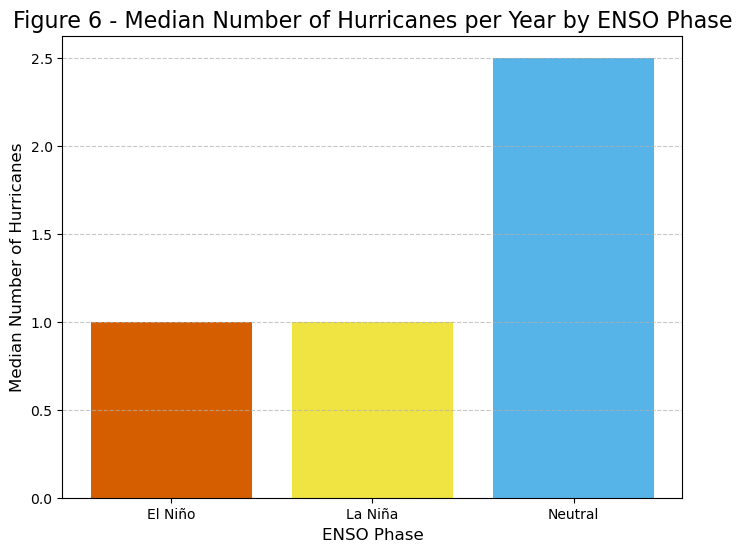

In [25]:
# Count the number of unique hurricanes per year for each ENSO phase
fig_counter = fig_counter + 1 
hurricanes_per_year = df2.groupby(["Year", "ENSO"])["Name"].nunique().reset_index(name="Hurricane Count")

# Calculate the median number of hurricanes for each ENSO phase
median_hurricanes = hurricanes_per_year.groupby("ENSO")["Hurricane Count"].median().reset_index()

# Plot the median number of hurricanes for each ENSO phase
plt.figure(figsize=(8, 6))
plt.bar(median_hurricanes["ENSO"], median_hurricanes["Hurricane Count"], color=["#D55E00", "#F0E442", "#56B4E9"])
plt.title("Figure " + str(fig_counter) + " - Median Number of Hurricanes per Year by ENSO Phase", fontsize=16)
plt.xlabel("ENSO Phase", fontsize=12)
plt.ylabel("Median Number of Hurricanes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Figure 6 illustrates that the median number of Hurricanes per year is highest for neutral ENSO years (2.5 median), and El Niño and La Niña have equal number of Category 1 storms or higher at 1.00.

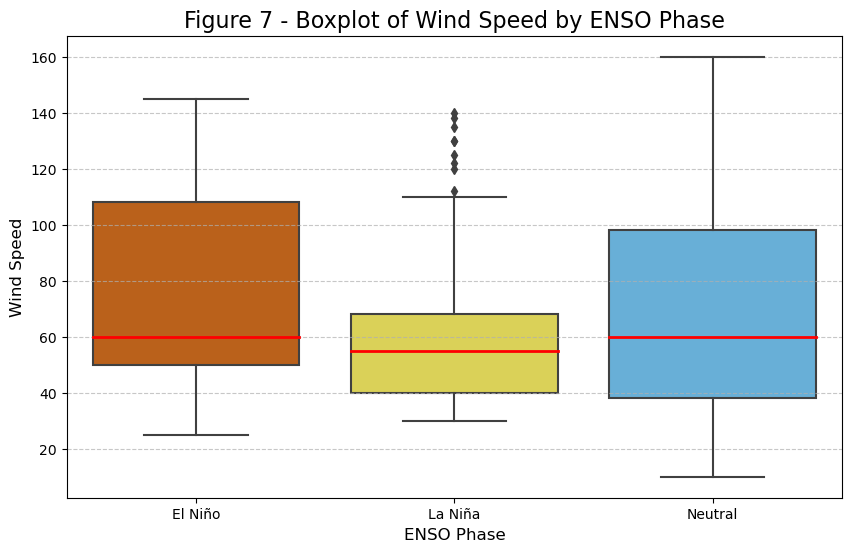

In [26]:
import seaborn as sns
fig_counter = fig_counter + 1 
# Define the custom color palette
custom_palette = ["#D55E00", "#F0E442", "#56B4E9"]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df2, x="ENSO", y="USA WIND", showfliers=True, palette=custom_palette, medianprops={"color": "red", "linewidth": 2})

# Add plot details
plt.title("Figure " + str(fig_counter) +" - Boxplot of Wind Speed by ENSO Phase", fontsize=16)
plt.xlabel("ENSO Phase", fontsize=12)
plt.ylabel("Wind Speed", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Figure 7 illustrates that the medians windspeeds are similar, but the neutral ENSO phase has the longest whiskers which indicates the most variance, while La Niña has the smallest variance, but alot of outliers. 

Weather experts often also commonly report their expectation for the wind speed to fall once the storm reaches landfall, meaning that the storm sustains a trajectory onto and over a substantial landmass.  The following subplot demonstrates an analysis showing each storm plotted over it's duration, its mean, median, and at what point the storm center falls over land.  This is helpful in understanding the the change in the nature of the storm when over land rather than the warm ocean.

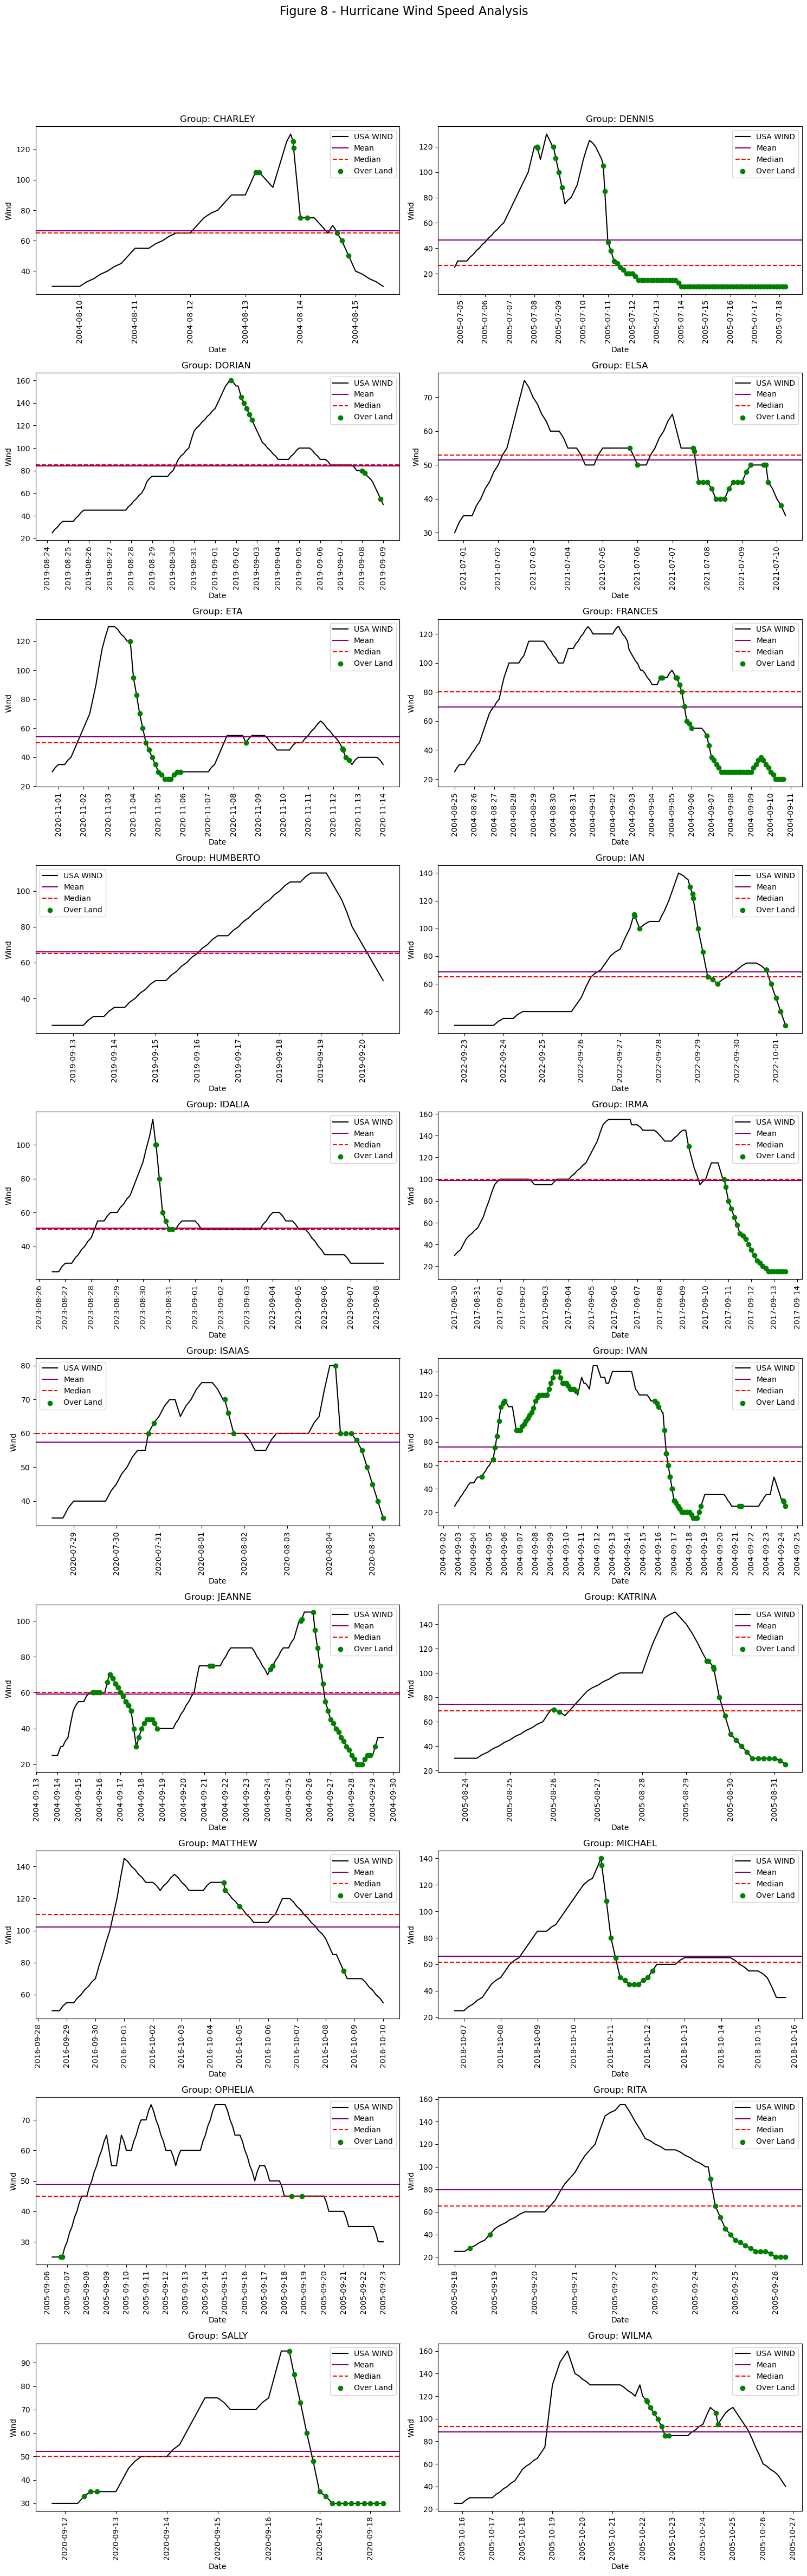

In [27]:
import math
import matplotlib.dates as mdates
fig_counter = fig_counter + 1 
# Convert ISO_TIME to datetime
df2['ISO_TIME'] = pd.to_datetime(df2['ISO_TIME'])

# Group by 'Name' and calculate mean and median for each group
grouped = df2.groupby('Name')['USA WIND'].agg(['mean', 'median'])

# Determine the number of rows and columns for the grid
num_plots = len(grouped)
num_cols = 2  # You can adjust this value based on your preference
num_rows = math.ceil(num_plots / num_cols)

# Plotting
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (name, group) in enumerate(grouped.iterrows()):
    ax = axes[i]
    group_data = df2[df2['Name'] == name]
    ax.plot(group_data['ISO_TIME'], group_data['USA WIND'], color='black', label='USA WIND')
    ax.axhline(y=group['mean'], color='purple', linestyle='-', label='Mean')
    ax.axhline(y=group['median'], color='red', linestyle='--', label='Median')
    
    # Add points where LAND is "Y"
    land_points = group_data[group_data['LAND'] == 'Y']
    ax.scatter(land_points['ISO_TIME'], land_points['USA WIND'], color='green', label='Over Land', zorder=5)
    
    ax.set_title(f'Group: {name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Wind')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=90)  # Rotate x tick labels vertically

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title to the plot
fig.suptitle('Figure ' + str(fig_counter) + ' - Hurricane Wind Speed Analysis', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
plt.show()

Figure 8 shows that in general we can see that wind speed builds throughout the life of the storm while it is on the ocean, then in general, once it gets over land, it starts to slow down.  The point where the storm arrives over land, the wind is still very much greater than the arithmetic mean or median wind of the storm.  This is why "where" it makes landfall is so important.  This point is the place that is going to be hit with the strongest winds of any other place over land (most of the time).  This confirms the statements often heard by weather experts.  
Is there a better way to summarize this, and add the standard deviation?

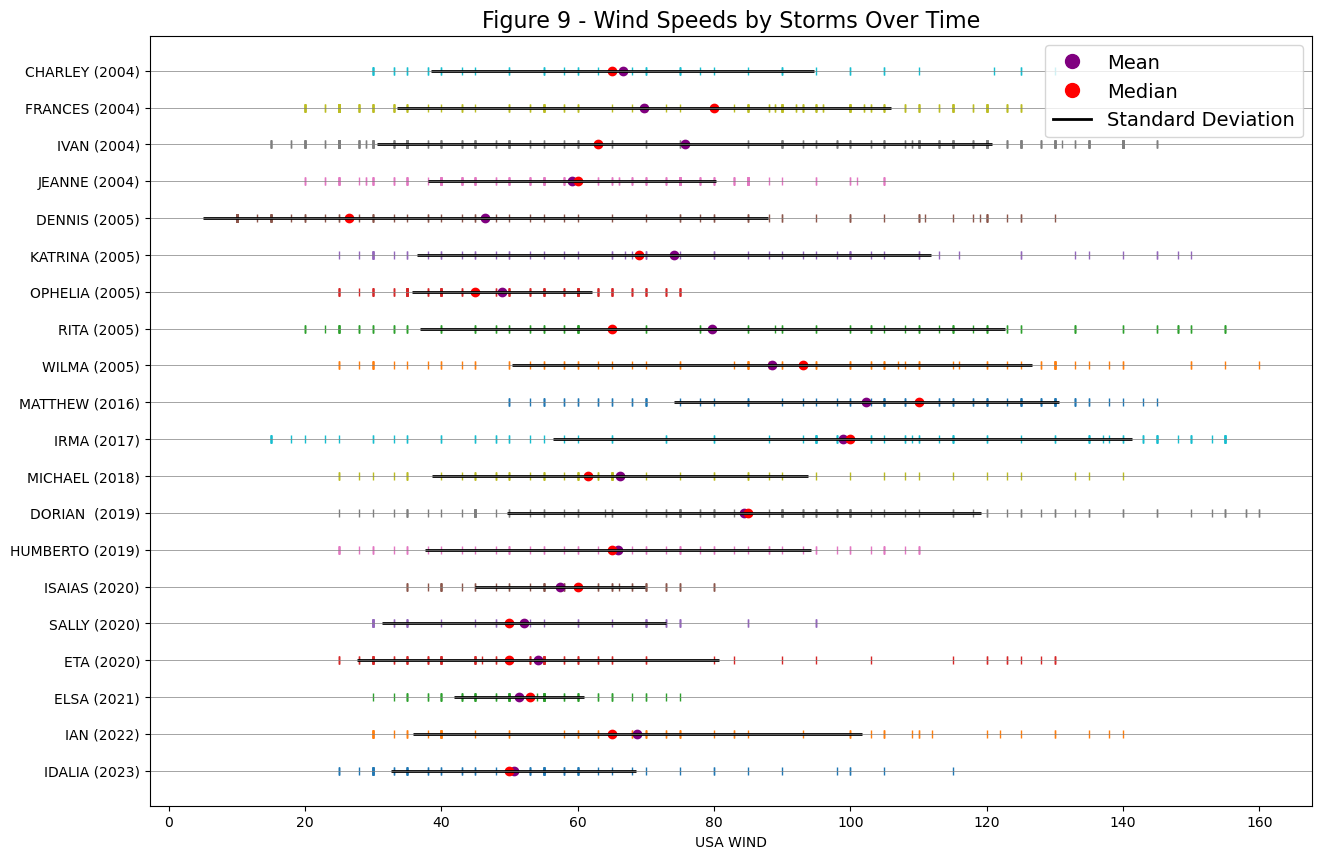

In [28]:
import matplotlib.lines as mlines
fig_counter = fig_counter + 1 
# Convert ISO_TIME to datetime
df2['ISO_TIME'] = pd.to_datetime(df2['ISO_TIME'])

# Sort the DataFrame by ISO_TIME within each group
df2 = df2.sort_values(by=['ISO_TIME'], ascending=False)

# Group by 'Name' and calculate mean, median, and standard deviation for each group
grouped = df2.groupby('Name')['USA WIND'].agg(['mean', 'median', 'std'])

# Plotting USA WIND on a series of stacked number lines
fig, ax = plt.subplots(figsize=(15, 10))

# Get unique names sorted by the first occurrence of ISO_TIME
unique_names = df2.drop_duplicates(subset='Name').sort_values(by='ISO_TIME', ascending=False)['Name']

for i, name in enumerate(unique_names):
    group = df2[df2['Name'] == name]
    y = [i] * len(group)
    ax.plot(group['USA WIND'], y, '|', label=f'{name} - USA WIND')
    ax.plot(grouped.loc[name, 'mean'], i, 'o', color='purple', label=f'{name} - Mean')
    ax.plot(grouped.loc[name, 'median'], i, 'o', color='red', label=f'{name} - Median')
    ax.hlines(i, grouped.loc[name, 'mean'] - grouped.loc[name, 'std'], grouped.loc[name, 'mean'] + grouped.loc[name, 'std'], color='black', linestyle='-', linewidth=2)
    ax.axhline(y=i, color='gray', linestyle='-', linewidth=0.5)

# Custom legend handles
mean_handle = mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=10, label='Mean')
median_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Median')
std_handle = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='Standard Deviation')

ax.set_yticks(range(len(unique_names)))
ax.set_yticklabels([f"{name} ({df[df['Name'] == name]['Year'].iloc[0]})" for name in unique_names])
ax.set_xlabel('USA WIND')
ax.set_title('Figure ' + str(fig_counter)+ ' - Wind Speeds by Storms Over Time', fontsize=16)
ax.legend(handles=[mean_handle, median_handle, std_handle], fontsize=14)

plt.show()

Next, consider a KDE plot of the aggregated means and overlay this with the entire dataset's KDE of Wind above.

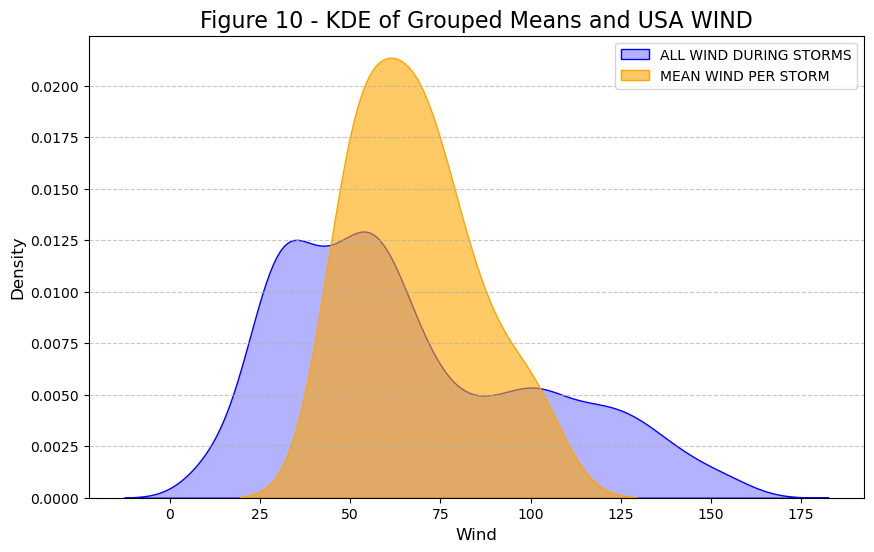

In [29]:
# Group by 'Name' and calculate mean for each group
fig_counter = fig_counter + 1 
grouped = df2.groupby('Name')['USA WIND'].agg(['mean'])

# Group by 'Name' and calculate mean for each group
grouped = df2.groupby('Name')['USA WIND'].agg(['mean'])

# Plotting KDE of means and KDE for 'USA WIND' on one plot
plt.figure(figsize=(10, 6))

# KDE for 'USA WIND' in the background
sns.kdeplot(data=df, x="USA WIND", fill=True, color="blue", alpha=0.3, label='ALL WIND DURING STORMS')

# KDE of grouped means in the foreground
sns.kdeplot(grouped['mean'], fill=True, color="orange", alpha=0.6, label='MEAN WIND PER STORM')

plt.title('Figure ' + str(fig_counter)+ ' - KDE of Grouped Means and USA WIND', fontsize=16)
plt.xlabel('Wind', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


So this KDE plot shown as Figure 12 allows us to estimate the probability density function from the mean winds of each storm in comparison to the probability density function of the overall data set.  What does this mean?  The orange grouped means KDE has a single peak, seen in normal distributions, it is also tall and narrow, suggesting that the arithmetic means for each storm are very close around the mean of all of those values, so there is low variance in the means.  The blue "All WIND DURING STORMS" KDE plot is approaching bimodal, and is wide, and skewed right, meaning that there is higher variance among the winds in the entire data set, and most of the winds are in the 25 to 75 mile per hour range, with less of the wind in the very high ranges.

RELATIONSHIPS BETWEEN THE DATA VARIABLES

Are there relationships between any of the variables in the dataset?  A linear regression between variables may illustrate if one variable has a causal relationship toward another.  So for this dataset, does the max pressure of the storm influence the life of the storm as measured by the total distance traveled?  Both variables are continuous, so linear regression can be used. The null hypothesis (H0) is that total distance traveled (y) is independent (or not related to) the minimum pressure of the storm (x).  Reminder - we use minimum pressure here, not maximum, because minimum pressure (low pressure) is the sign of the strong storm with strongest winds!!!

In [30]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import scipy.stats as stats

# Function to calculate distance between two points (latitude and longitude)
from geopy.distance import geodesic

# Function to calculate distance between two points (latitude and longitude)
def calculate_distance(point1, point2):
    return geodesic(point1, point2).miles

# Calculate the sum of distances by group and sort by Year
groupedLR = df2.groupby(['Year', 'Name'])
distances = {}

for (year, name), group in groupedLR:
    total_distance = 0
    points = list(zip(group['LAT'], group['LON']))
    for i in range(len(points) - 1):
        total_distance += calculate_distance(points[i], points[i + 1])
    distances[(year, name)] = total_distance

# Sort distances by Year
sorted_distances = dict(sorted(distances.items(), key=lambda item: item[0]))

# Find the min pressure for each 'Name'
min_pressure = groupedLR['WMO PRES'].min()

# Add min pressure as a column joined to 'Name' in sorted_distances
sorted_distances_with_pressure = []
for (year, name), distance in sorted_distances.items():
    sorted_distances_with_pressure.append({
        'Year': year,
        'Name': name,
        'Total Distance': distance,
        'Min Pressure': min_pressure.loc[(year, name)]
    })

# Convert to DataFrame for better readability
DistPresLR = pd.DataFrame(sorted_distances_with_pressure)

print(DistPresLR)

    Year      Name  Total Distance  Min Pressure
0   2004   CHARLEY     3303.684835         941.0
1   2004   FRANCES     5308.826388         935.0
2   2004      IVAN     7708.572316         910.0
3   2004    JEANNE     3676.146375         950.0
4   2005    DENNIS     3786.379482         930.0
5   2005   KATRINA     2111.594383         902.0
6   2005   OPHELIA     5398.829765         976.0
7   2005      RITA     2472.821624         895.0
8   2005     WILMA     3485.225548         882.0
9   2016   MATTHEW     3008.810647         934.0
10  2017      IRMA     4793.310476         914.0
11  2018   MICHAEL     5312.890591         919.0
12  2019   DORIAN      4830.430707         910.0
13  2019  HUMBERTO     2075.938503         950.0
14  2020       ETA     3942.738997         922.0
15  2020    ISAIAS     3481.771931         986.0
16  2020     SALLY     1257.611304         965.0
17  2021      ELSA     4903.446252         991.0
18  2022       IAN     2517.617253         937.0
19  2023    IDALIA  

What does this tell us?  Visually there is a slight correlation.  But let's quantify that by calculating the residuals, then doing some tests to calculate the p-value of the linear regression.

In [31]:
### Linear Regression of Minimum Pressure and Total Distance Traveled

# Extract the relevant columns
X = DistPresLR[['Min Pressure']]
y = DistPresLR['Total Distance']

# Create and fit the linear regression model
modelDistPres = LinearRegression()
modelDistPres.fit(X, y)

# Predict values
y_predDistPres = modelDistPres.predict(X)

# Calculate residuals
residuals = y - y_predDistPres

# Print residuals
#print("Residuals:")
#print(residuals)

In [32]:
# Perform Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

Shapiro-Wilk test statistic: 0.9614865183830261, p-value: 0.5739571452140808


Since the p-value is greater than 0.05, we fail to reject the null hypothesis. That is, we can't reject that total distance traveled is not related to the maximum pressure of the storm. But what is the strength of the relationship, if it is there?  The coefficient of determination will give us a value that helps us better quantify the strength of the significant relationship.

In [33]:
from sklearn.metrics import r2_score
# Calculate the coefficient of determination (R^2)
r2 = r2_score(y, y_predDistPres)

print(f"Coefficient of Determination (R^2): {r2}")

Coefficient of Determination (R^2): 0.002652713347976454


So 0.003, or 0.3% of the variation in the dependent variable (distance that the storm travels) can be explained by knowing the minimum pressure of the storm.  That is very small.  So the relationship is not very strong, and you could even say there is really no relationship.  In other words the proportion of variation explained by the independent variable is so small, that we can not be very confident in the causality relationship of minimum pressure in a storm to the distance that the storm travels. 


### Parametric and Non-Parametric stats: 

We're going to cover T-tests Parametric and KS tests non-parametric in this section. 

Can we do any other tests to further evaluate the relationship of these two variables?
Let's start with a basic T-test.  
##### Parametric: T-Test

In [35]:
import numpy as np

from scipy.stats import ttest_ind
# Perform t-test on Min Pressure and Total Distance
t_stat, p_value = ttest_ind(DistPresLR['Min Pressure'], DistPresLR['Total Distance'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -8.725733775734884
P-value: 1.3077360086589028e-10


The negative t-statistic indicates that the mean of Minimum Pressure is significantly lower than the mean of Total Distance. The extremely low p-value suggests that this difference is statistically significant. But as shown above the confidence associated with their relationship is very low (0.3% from above).

##### Non-Parametric: KS-Test

Lets explore some NON-PARAMETRIC statistics, specifically the Kolmogorov-Smirnov (KS) test. The KS Test is a nonparametric statistical test that compares two distributions to determine if they are different. 

In [36]:
from scipy.stats import ks_2samp
import pandas as pd


#data = pd.read_csv("GEO557Tropical_Storm_Dataset_CLEAN.csv")
# Group by 'Name' and 'Year' to get the maximum 'USA WIND' for each hurricane
max_wind_per_hurricane = df2.groupby(['Name', 'Year'])['USA WIND'].max().reset_index()

# Split into two time periods
first_half = max_wind_per_hurricane[(max_wind_per_hurricane['Year'] >= 2000) & 
                                    (max_wind_per_hurricane['Year'] <= 2011)]['USA WIND'].dropna()
second_half = max_wind_per_hurricane[(max_wind_per_hurricane['Year'] >= 2012) & 
                                     (max_wind_per_hurricane['Year'] <= 2023)]['USA WIND'].dropna()

# Perform the KS test
ks_statistic, p_value = ks_2samp(first_half, second_half)

# Output results
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The distributions of maximum hurricane winds are significantly different (p < 0.05).")
else:
    print("The distributions of maximum hurricane winds are not significantly different between 2000-2011 and 2012-2023 (p ≥ 0.05).")

KS Statistic: 0.23232323232323232
P-Value: 0.8943319838056679
The distributions of maximum hurricane winds are not significantly different between 2000-2011 and 2012-2023 (p ≥ 0.05).


Based on this analysis, the results suggest wind speed distributions aren't different enough to be statistically significant across the two time frames.
Lets try another KS test to see if we find anything else interesting. 

In [38]:
from scipy.stats import ks_2samp
import pandas as pd

# Load data
#data = pd.read_csv("GEO557Tropical_Storm_Dataset_CLEAN.csv")

# Group by 'Name' and 'Year' to get the minimum 'USA PRES' for each hurricane
min_pres_per_hurricane = df2.groupby(['Name', 'Year'])['USA PRES'].min().reset_index()

# Split into two time periods
first_half = min_pres_per_hurricane[(min_pres_per_hurricane['Year'] >= 2000) & 
                                    (min_pres_per_hurricane['Year'] <= 2011)]['USA PRES'].dropna()
second_half = min_pres_per_hurricane[(min_pres_per_hurricane['Year'] >= 2012) & 
                                     (min_pres_per_hurricane['Year'] <= 2023)]['USA PRES'].dropna()

# Perform the KS test
ks_statistic, p_value = ks_2samp(first_half, second_half)


# Output results
print(f"KS Statistic: {ks_statistic}")
print(f"P-Value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The distributions of minimum hurricane pressures are significantly different (p < 0.05).")
else:
    print("The distributions of minimum hurricane pressures are not significantly different between 2000-2011 and 2012-2023 (p ≥ 0.05).")

KS Statistic: 0.35353535353535354
P-Value: 0.4565372707787569
The distributions of minimum hurricane pressures are not significantly different between 2000-2011 and 2012-2023 (p ≥ 0.05).


These results state the same thing as the last ones, so based on this dataset we can't detect a difference between the minimum pressures between 2000 and 2011 vs. 2012 and 2023.

In the next block of code we're going to do a few KS tests to see if La Niña, El Niño, or neutral ENSO will have a different max wind distribution. 

In [39]:
from scipy.stats import ks_2samp
import pandas as pd

# Load merged dataset
#data = pd.read_csv("Tropical_Storm_Dataset_AND_ENSO.csv")

# Group by 'Name' and 'Year' to get the maximum 'USA WIND' for each hurricane
max_wind_per_hurricane = df2.groupby(['Name', 'Year'])['USA WIND'].max().reset_index()

# Merge the ENSO phase information back in based on the year
max_wind_per_hurricane = pd.merge(max_wind_per_hurricane, df2[['Year', 'ENSO']].drop_duplicates(), on='Year', how='left')

# Filter by ENSO phases
el_nino = max_wind_per_hurricane[max_wind_per_hurricane['ENSO'] == 'El Niño']['USA WIND'].dropna()
la_nina = max_wind_per_hurricane[max_wind_per_hurricane['ENSO'] == 'La Niña']['USA WIND'].dropna()
neutral = max_wind_per_hurricane[max_wind_per_hurricane['ENSO'] == 'Neutral']['USA WIND'].dropna()

# Perform KS test between El Niño and La Niña
ks_statistic_elnino_lanina, p_value_elnino_lanina = ks_2samp(el_nino, la_nina)
print("El Niño vs La Niña:")
print(f"KS Statistic: {ks_statistic_elnino_lanina}")
print(f"P-Value: {p_value_elnino_lanina}")
if p_value_elnino_lanina < 0.05:
    print("Distributions of max USA WIND are significantly different between El Niño and La Niña (p < 0.05).")
else:
    print("Distributions of max USA WIND are not significantly different between El Niño and La Niña (p ≥ 0.05).")

# Perform KS test between El Niño and Neutral
ks_statistic_elnino_neutral, p_value_elnino_neutral = ks_2samp(el_nino, neutral)
print("\nEl Niño vs Neutral:")
print(f"KS Statistic: {ks_statistic_elnino_neutral}")
print(f"P-Value: {p_value_elnino_neutral}")
if p_value_elnino_neutral < 0.05:
    print("Distributions of max USA WIND are significantly different between El Niño and Neutral (p < 0.05).")
else:
    print("Distributions of max USA WIND are not significantly different between El Niño and Neutral (p ≥ 0.05).")

# Perform KS test between La Niña and Neutral
ks_statistic_lanina_neutral, p_value_lanina_neutral = ks_2samp(la_nina, neutral)
print("\nLa Niña vs Neutral:")
print(f"KS Statistic: {ks_statistic_lanina_neutral}")
print(f"P-Value: {p_value_lanina_neutral}")
if p_value_lanina_neutral < 0.05:
    print("Distributions of max USA WIND are significantly different between La Niña and Neutral (p < 0.05).")
else:
    print("Distributions of max USA WIND are not significantly different between La Niña and Neutral (p ≥ 0.05).")


El Niño vs La Niña:
KS Statistic: 0.5
P-Value: 1.0
Distributions of max USA WIND are not significantly different between El Niño and La Niña (p ≥ 0.05).

El Niño vs Neutral:
KS Statistic: 0.3125
P-Value: 0.9934640522875817
Distributions of max USA WIND are not significantly different between El Niño and Neutral (p ≥ 0.05).

La Niña vs Neutral:
KS Statistic: 0.4375
P-Value: 0.8366013071895425
Distributions of max USA WIND are not significantly different between La Niña and Neutral (p ≥ 0.05).


Looks like MAX wind are not significantly different between the three ENSO types and this dataset. 

In [40]:
from scipy.stats import ks_2samp
import pandas as pd

# Load merged dataset
#data = pd.read_csv("Tropical_Storm_Dataset_AND_ENSO.csv")

# Count the number of storms
storm_counts_per_year = df2.groupby(['Year', 'ENSO'])['Name'].nunique().reset_index(name='Storm_Count')

#filter storm counts
el_nino_counts = storm_counts_per_year[storm_counts_per_year['ENSO'] == 'El Niño']['Storm_Count']
la_nina_counts = storm_counts_per_year[storm_counts_per_year['ENSO'] == 'La Niña']['Storm_Count']
neutral_counts = storm_counts_per_year[storm_counts_per_year['ENSO'] == 'Neutral']['Storm_Count']

# Perform KS tests
ks_statistic_elnino_lanina, p_value_elnino_lanina = ks_2samp(el_nino_counts, la_nina_counts)
print("El Niño vs La Niña (Number of Storms per Year):")
print(f"KS Statistic: {ks_statistic_elnino_lanina}")
print(f"P-Value: {p_value_elnino_lanina}")

if p_value_elnino_lanina < 0.05:
    print("Distributions of storm counts per year are significantly different between El Niño and La Niña (p < 0.05).")
else:
    print("Distributions of storm counts per year are not significantly different between El Niño and La Niña (p ≥ 0.05).")

ks_statistic_elnino_neutral, p_value_elnino_neutral = ks_2samp(el_nino_counts, neutral_counts)
print("\nEl Niño vs Neutral (Number of Storms per Year):")
print(f"KS Statistic: {ks_statistic_elnino_neutral}")
print(f"P-Value: {p_value_elnino_neutral}")
if p_value_elnino_neutral < 0.05:
    print("Distributions of storm counts per year are significantly different between El Niño and Neutral (p < 0.05).")
else:
    print("Distributions of storm counts per year are not significantly different between El Niño and Neutral (p ≥ 0.05).")

# Perform KS test between La Niña and Neutral storm counts
ks_statistic_lanina_neutral, p_value_lanina_neutral = ks_2samp(la_nina_counts, neutral_counts)
print("\nLa Niña vs Neutral (Number of Storms per Year):")
print(f"KS Statistic: {ks_statistic_lanina_neutral}")
print(f"P-Value: {p_value_lanina_neutral}")
if p_value_lanina_neutral < 0.05:
    print("Distributions of storm counts per year are significantly different between La Niña and Neutral (p < 0.05).")
else:
    print("Distributions of storm counts per year are not significantly different between La Niña and Neutral (p ≥ 0.05).")



El Niño vs La Niña (Number of Storms per Year):
KS Statistic: 0.0
P-Value: 1.0
Distributions of storm counts per year are not significantly different between El Niño and La Niña (p ≥ 0.05).

El Niño vs Neutral (Number of Storms per Year):
KS Statistic: 0.6666666666666666
P-Value: 0.42857142857142855
Distributions of storm counts per year are not significantly different between El Niño and Neutral (p ≥ 0.05).

La Niña vs Neutral (Number of Storms per Year):
KS Statistic: 0.6666666666666666
P-Value: 0.42857142857142855
Distributions of storm counts per year are not significantly different between La Niña and Neutral (p ≥ 0.05).


It looks like the counts of storms per year are not siginificantly different between the three ENSO types. 
So this data set is not showing alot with KS tests, that could suggest, either these distributions aren't significantly different or maybe our dataset isn't large enough.  
My hypothesis at this time, is that the size of the dataset of 23 storms might not be large enough or diverse enough to capture trends in the distributions. 

# Section 4:  Conclusion (Discussion) 

Based on the findings above, we have come to recognize nuanced relationships between ENSO phases and hurricane activity. While visualizations and statistical tests provide some evidence of ENSO-related variability in storm frequency and intensity, many differences are not statistically significant. This data set makes us wonder if other climate factors may play a more substantial role in shaping hurricane dynamics. Our study integrates multiple differente datasets to explore trends in hurricanes from 2000 to 2023. Future work could expand on these findings by incorporating additional storms in the study, such as the ones that didn't reach Category 1 level or higher, or other variables completely,  such as surface temperature or ocean temperature at the storm location. 

### The End

##### Thank you for coming on this stats journey with us!